In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, AveragePooling2D

Using TensorFlow backend.


In [4]:
n_coef = 16

In [5]:
brain_regions = np.genfromtxt('/Users/linggeli/graph_fmri/clas_data/brain_regions.csv', dtype=int, delimiter=',')[:40] - 1

In [6]:
X = np.load('/Users/linggeli/graph_fmri/clas_data/features_259subjects_filtered.npy')[:, brain_regions, :n_coef]
y = np.load('/Users/linggeli/graph_fmri/clas_data/labels_259subjects.npy')

In [7]:
print(X.shape)
print(y.shape)

(1036, 40, 16)
(1036,)


In [8]:
n_train = 700
n_val = 300

np.random.seed(0)
indices = np.random.permutation(X.shape[0])

In [9]:
X_train = X[indices[:n_train]]
X_val   = X[indices[n_train:n_train+n_val]]
X_test  = X[indices[n_train+n_val:]]

y_train = y[indices[:n_train]]
y_val   = y[indices[n_train:n_train+n_val]]
y_test  = y[indices[n_train+n_val:]]

In [10]:
from sklearn import preprocessing

In [11]:
X_vec = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
X_vec = preprocessing.scale(X_vec)
X_train_vec = X_vec[indices[:n_train]]
X_val_vec   = X_vec[indices[n_train:n_train+n_val]]
X_test_vec  = X_vec[indices[n_train+n_val:]]

In [12]:
print(X_train_vec.shape)

(700, 640)


In [13]:
model = LogisticRegressionCV(cv=10, penalty='l1', solver='liblinear')

In [14]:
model.fit(X_train_vec, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [15]:
print(model.C_[0])

0.0464158883361


In [16]:
y_hat = model.predict(X_val_vec)
print(np.mean(y_hat == y_val))

0.753333333333


In [17]:
model = Sequential()
model.add(Dense(200, input_shape=(X_train_vec.shape[1],), activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               128200    
_________________________________________________________________
dense_2 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 137,081
Trainable params: 137,081
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
hist = model.fit(X_train_vec, y_train, batch_size=100, epochs=10, validation_data=(X_val_vec, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 1s 972us/step - loss: 0.7250 - acc: 0.5771 - val_loss: 0.5648 - val_acc: 0.7167
Epoch 2/10
700/700 [==============================] - 0s 74us/step - loss: 0.4721 - acc: 0.7943 - val_loss: 0.5455 - val_acc: 0.7500
Epoch 3/10
700/700 [==============================] - 0s 86us/step - loss: 0.3595 - acc: 0.8643 - val_loss: 0.5206 - val_acc: 0.7733
Epoch 4/10
700/700 [==============================] - 0s 98us/step - loss: 0.2715 - acc: 0.9157 - val_loss: 0.4980 - val_acc: 0.8033
Epoch 5/10
700/700 [==============================] - 0s 103us/step - loss: 0.1980 - acc: 0.9543 - val_loss: 0.5099 - val_acc: 0.8000
Epoch 6/10
700/700 [==============================] - 0s 115us/step - loss: 0.1469 - acc: 0.9729 - val_loss: 0.5414 - val_acc: 0.8000
Epoch 7/10
700/700 [==============================] - 0s 106us/step - loss: 0.1063 - acc: 0.9829 - val_loss: 0.5675 - val_acc: 0.7900
Epoch 8/10
700/700 

In [20]:
y_hat = model.predict(X_val_vec)[:, 0]
print(y_hat.shape)

(300,)


In [21]:
fpr, tpr, _ = roc_curve(y_val, y_hat)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.854029532112


Text(0,0.5,u'True Positive Rate')

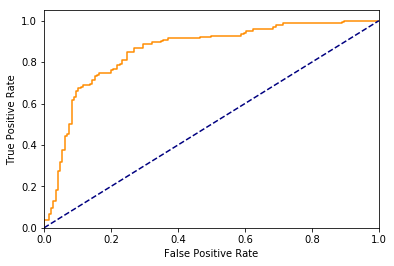

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [28]:
n_filter = 10
dense_size = 40

In [29]:
input_image = Input(shape=(40, 16, 1))
x = Conv2D(n_filter, (4, 4), padding='same', activation='relu')(input_image)
x = AveragePooling2D((4, 4))(x)
x = Flatten()(x)
x = Dense(dense_size, activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(1, activation='sigmoid')(x)
conv_model = Model(input_image, y)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 16, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 16, 10)        170       
_________________________________________________________________
average_pooling2d_2 (Average (None, 10, 4, 10)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 40)                16040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total para

In [30]:
conv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
X_train = (X_train - np.mean(X)) / np.std(X)
X_val = (X_val - np.mean(X)) / np.std(X)
X_train_image = np.expand_dims(X_train, axis=-1)
X_val_image = np.expand_dims(X_val, axis=-1)

In [31]:
conv_model.fit(X_train_image, y_train, batch_size=100, epochs=10, verbose=1, validation_data=(X_val_image, y_val))

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 1s 1ms/step - loss: 0.6753 - acc: 0.6014 - val_loss: 0.6339 - val_acc: 0.6800
Epoch 2/10
700/700 [==============================] - 0s 273us/step - loss: 0.6196 - acc: 0.6714 - val_loss: 0.5943 - val_acc: 0.7300
Epoch 3/10
700/700 [==============================] - 0s 273us/step - loss: 0.5845 - acc: 0.7271 - val_loss: 0.5737 - val_acc: 0.7000
Epoch 4/10
700/700 [==============================] - 0s 318us/step - loss: 0.5672 - acc: 0.7386 - val_loss: 0.5643 - val_acc: 0.7100
Epoch 5/10
700/700 [==============================] - 0s 285us/step - loss: 0.5512 - acc: 0.7400 - val_loss: 0.5609 - val_acc: 0.7000
Epoch 6/10
700/700 [==============================] - 0s 288us/step - loss: 0.5423 - acc: 0.7371 - val_loss: 0.5519 - val_acc: 0.7200
Epoch 7/10
700/700 [==============================] - 0s 415us/step - loss: 0.5466 - acc: 0.7443 - val_loss: 0.5461 - val_acc: 0.7100
Epoch 8/10
700/700